In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/skripsi/model2_dauntomat.h5'

/content/drive/MyDrive/skripsi/model2_dauntomat.h5


In [ ]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

In [ ]:
model_path = '/content/drive/MyDrive/skripsi/model2_dauntomat.h5'
model = load_model(model_path)


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/skripsi/train',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True
)

Found 5002 files belonging to 10 classes.


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=5000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=2,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.00001)

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

17/17 [==============================] - 580s 18ms/step - loss: 0.1259 - accuracy: 0.9890
Loss: 0.12594538927078247
Accuracy: 0.9889705777168274


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [ ]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


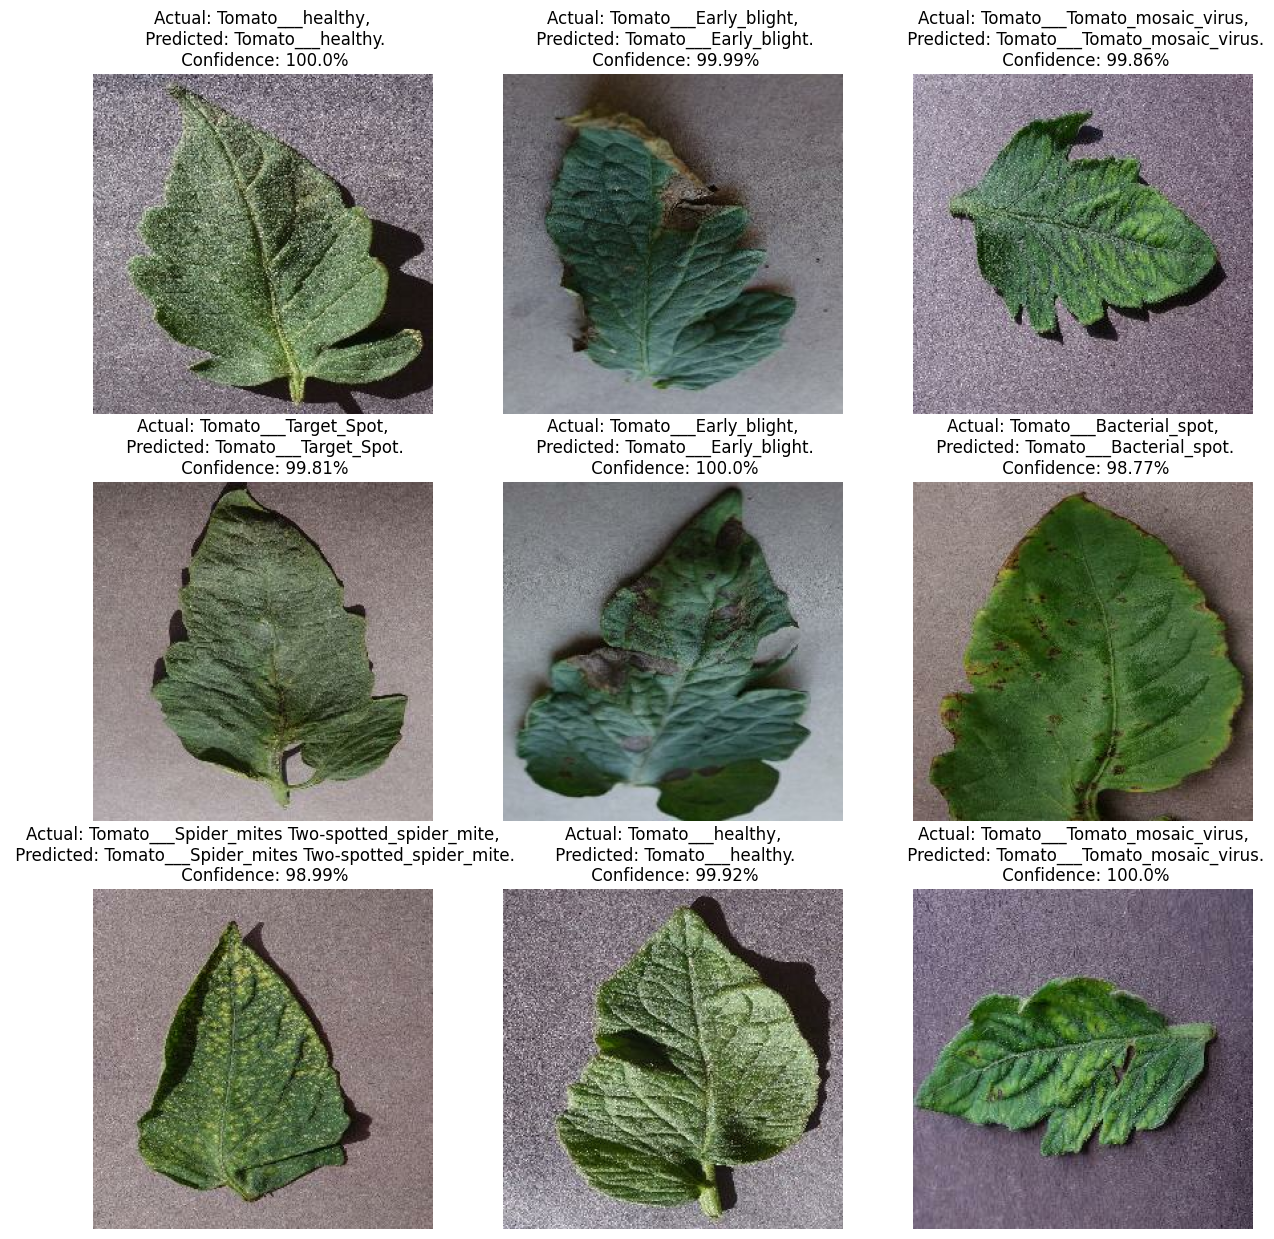

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")